In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings
import torch
import gc
from PIL import Image
from collections import Counter

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available - using CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
warnings.filterwarnings('ignore')


CUDA available: True
CUDA device: Tesla V100-SXM2-32GB
CUDA memory allocated: 0.00 MB
Using device: cuda


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load labels
data_dir = "./Nonastreda_Multimodal"
labels_df = pd.read_csv(os.path.join(data_dir, "labels.csv"))
labels_reg_df = pd.read_csv(os.path.join(data_dir, "labels_reg.csv"))
full_df = pd.merge(labels_df, labels_reg_df, on='id')

full_df['tool'] = full_df['id'].str.extract(r'T(\d+)').astype(int)

print("NONASTREDA DATASET - EXPLORATORY DATA ANALYSIS")

print(f"\n Dataset Overview:")
print(f"   Total samples: {len(full_df)}")
print(f"   Number of tools: {full_df['tool'].nunique()}")
print(f"   Tool range: T{full_df['tool'].min()} - T{full_df['tool'].max()}")

print(f"\n Dataset Shape:")
print(full_df.head())

print(f"\n Data Types:")
print(full_df.dtypes)

print(f"\n Missing Values:")
print(full_df.isnull().sum())

print(f"\n Basic Statistics:")
print(full_df.describe())

NONASTREDA DATASET - EXPLORATORY DATA ANALYSIS

 Dataset Overview:
   Total samples: 512
   Number of tools: 10
   Tool range: T1 - T10

 Dataset Shape:
       id image_label  tool_label  gaps  flank_wear  overhang  tool
0  T1R2B1       sharp           1  7.67       34.89     48.61     1
1  T1R2B2       sharp           1  0.00       52.50     25.75     1
2  T1R2B3       sharp           1  7.07       52.76     21.56     1
3  T1R2B4       sharp           1  0.00       44.50      9.43     1
4  T1R3B1       sharp           1  9.44       39.90     17.89     1

 Data Types:
id              object
image_label     object
tool_label       int64
gaps           float64
flank_wear     float64
overhang       float64
tool             int64
dtype: object

 Missing Values:
id             0
image_label    0
tool_label     0
gaps           0
flank_wear     0
overhang       0
tool           0
dtype: int64

 Basic Statistics:
       tool_label        gaps  flank_wear    overhang        tool
count  512.000

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall class distribution
class_counts = full_df['tool_label'].value_counts().sort_index()
class_names = ['Sharp (0)', 'Used (1)', 'Dulled (2)']

axes[0, 0].bar(range(len(class_counts)), class_counts.values, 
               color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(class_counts)))
axes[0, 0].set_xticklabels(class_names, fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

total = len(full_df)
for i, v in enumerate(class_counts.values):
    axes[0, 0].text(i, v + 5, f'{v}\n({v/total*100:.1f}%)', 
                    ha='center', fontweight='bold', fontsize=10)

# 2. Class distribution per tool
class_per_tool = pd.crosstab(full_df['tool'], full_df['tool_label'])
class_per_tool.plot(kind='bar', ax=axes[0, 1], stacked=False, 
                    color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Tool', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Class Distribution per Tool', fontsize=14, fontweight='bold')
axes[0, 1].legend(['Sharp', 'Used', 'Dulled'], fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticklabels([f'T{i}' for i in range(1, 11)], rotation=45)

# 3. Samples per tool
samples_per_tool = full_df['tool'].value_counts().sort_index()
axes[1, 0].bar(samples_per_tool.index, samples_per_tool.values, 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Tool', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Samples per Tool', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].set_xticklabels([f'T{i}' for i in range(1, 11)])
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(samples_per_tool.values, 1):
    axes[1, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 4. Class distribution - stacked percentage
class_per_tool_pct = class_per_tool.div(class_per_tool.sum(axis=1), axis=0) * 100
class_per_tool_pct.plot(kind='bar', ax=axes[1, 1], stacked=True, 
                        color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Tool', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Class Distribution per Tool (Stacked %)', fontsize=14, fontweight='bold')
axes[1, 1].legend(['Sharp', 'Used', 'Dulled'], fontsize=10)
axes[1, 1].set_xticklabels([f'T{i}' for i in range(1, 11)], rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("CLASS DISTRIBUTION ANALYSIS")

print("\n Overall Class Balance:")
for i, (cls, count) in enumerate(class_counts.items()):
    pct = count / total * 100
    print(f"   Class {cls} ({class_names[i]}): {count} samples ({pct:.1f}%)")

print("\n Per-Tool Analysis:")
for tool in range(1, 11):
    tool_data = full_df[full_df['tool'] == tool]
    tool_classes = tool_data['tool_label'].value_counts().sort_index()
    print(f"\n   Tool T{tool} ({len(tool_data)} samples):")
    for cls in [1, 2, 3]:
        count = tool_classes.get(cls, 0)
        pct = count / len(tool_data) * 100 if len(tool_data) > 0 else 0
        print(f"      Class {cls}: {count:2d} ({pct:5.1f}%)")

CLASS DISTRIBUTION ANALYSIS

 Overall Class Balance:
   Class 1 (Sharp (0)): 192 samples (37.5%)
   Class 2 (Used (1)): 168 samples (32.8%)
   Class 3 (Dulled (2)): 152 samples (29.7%)

 Per-Tool Analysis:

   Tool T1 (40 samples):
      Class 1: 12 ( 30.0%)
      Class 2: 16 ( 40.0%)
      Class 3: 12 ( 30.0%)

   Tool T2 (56 samples):
      Class 1: 20 ( 35.7%)
      Class 2: 20 ( 35.7%)
      Class 3: 16 ( 28.6%)

   Tool T3 (52 samples):
      Class 1: 16 ( 30.8%)
      Class 2:  8 ( 15.4%)
      Class 3: 28 ( 53.8%)

   Tool T4 (40 samples):
      Class 1: 16 ( 40.0%)
      Class 2:  4 ( 10.0%)
      Class 3: 20 ( 50.0%)

   Tool T5 (48 samples):
      Class 1:  8 ( 16.7%)
      Class 2: 12 ( 25.0%)
      Class 3: 28 ( 58.3%)

   Tool T6 (60 samples):
      Class 1: 24 ( 40.0%)
      Class 2: 24 ( 40.0%)
      Class 3: 12 ( 20.0%)

   Tool T7 (56 samples):
      Class 1: 28 ( 50.0%)
      Class 2: 20 ( 35.7%)
      Class 3:  8 ( 14.3%)

   Tool T8 (52 samples):
      Class 1: 24 (

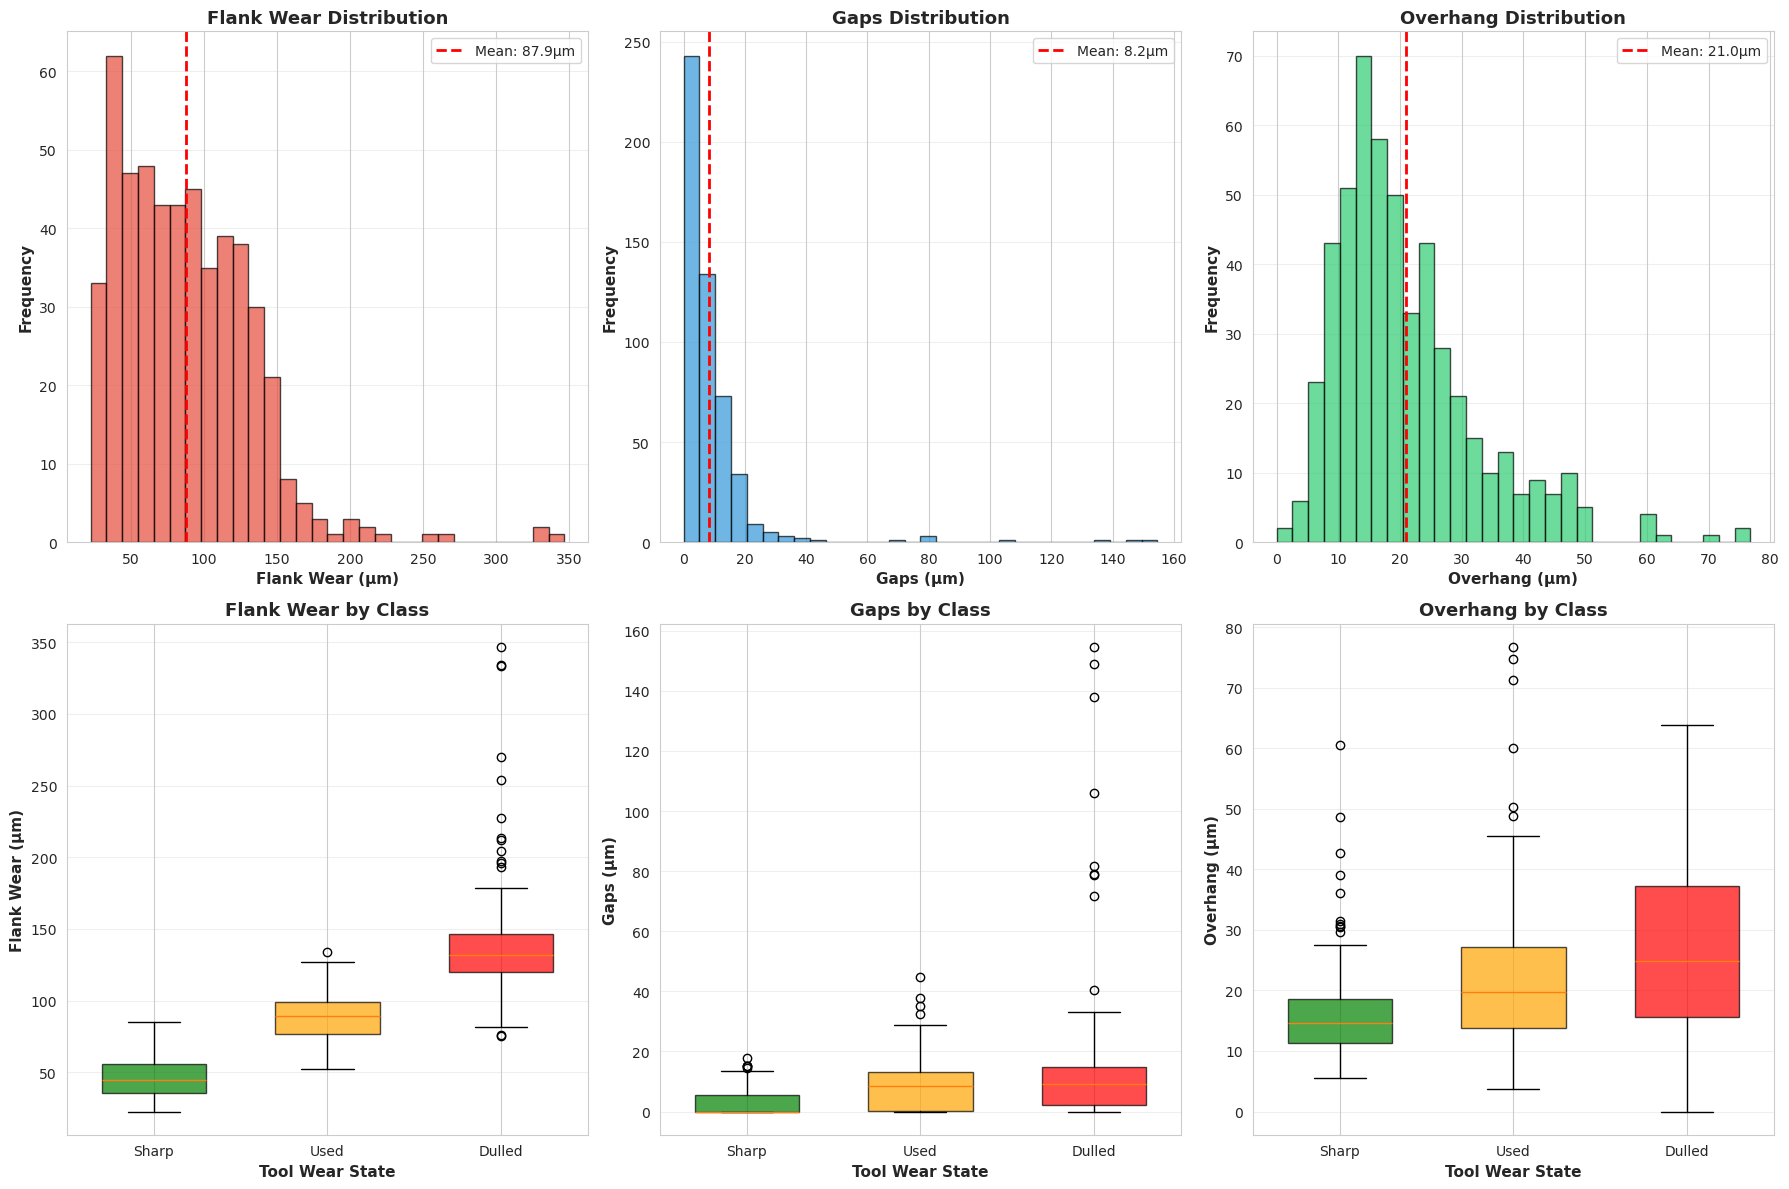

REGRESSION TARGET ANALYSIS

 Flank Wear:
   Mean:   87.86 µm
   Std:    45.52 µm
   Min:    22.55 µm
   Max:    346.66 µm
   Median: 82.18 µm

   By Class:
      Sharp   :  46.14 ± 12.64 µm
      Used    :  88.74 ± 15.77 µm
      Dulled  : 139.59 ± 40.36 µm

 Gaps:
   Mean:   8.20 µm
   Std:    15.05 µm
   Min:    0.00 µm
   Max:    154.56 µm
   Median: 5.77 µm

   By Class:
      Sharp   :   2.73 ±  3.96 µm
      Used    :   8.87 ±  7.84 µm
      Dulled  :  14.37 ± 24.54 µm

 Overhang:
   Mean:   20.95 µm
   Std:    11.78 µm
   Min:    0.00 µm
   Max:    76.75 µm
   Median: 18.25 µm

   By Class:
      Sharp   :  15.92 ±  7.52 µm
      Used    :  21.64 ± 12.00 µm
      Dulled  :  26.56 ± 13.19 µm


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

reg_targets = ['flank_wear', 'gaps', 'overhang']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (target, color) in enumerate(zip(reg_targets, colors)):
    # 1. Distribution histogram
    axes[0, idx].hist(full_df[target], bins=30, color=color, alpha=0.7, edgecolor='black')
    axes[0, idx].set_xlabel(f'{target.replace("_", " ").title()} (µm)', 
                            fontsize=11, fontweight='bold')
    axes[0, idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0, idx].set_title(f'{target.replace("_", " ").title()} Distribution', 
                           fontsize=13, fontweight='bold')
    axes[0, idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    mean_val = full_df[target].mean()
    std_val = full_df[target].std()
    axes[0, idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                         label=f'Mean: {mean_val:.1f}µm')
    axes[0, idx].legend(fontsize=10)
    
    # 2. Boxplot by class
    data_by_class = [full_df[full_df['tool_label'] == cls][target].values 
                     for cls in [ 1, 2, 3]]
    bp = axes[1, idx].boxplot(data_by_class, labels=['Sharp', 'Used', 'Dulled'],
                               patch_artist=True, widths=0.6)
    for patch, c in zip(bp['boxes'], ['green', 'orange', 'red']):
        patch.set_facecolor(c)
        patch.set_alpha(0.7)
    
    axes[1, idx].set_xlabel('Tool Wear State', fontsize=11, fontweight='bold')
    axes[1, idx].set_ylabel(f'{target.replace("_", " ").title()} (µm)', 
                            fontsize=11, fontweight='bold')
    axes[1, idx].set_title(f'{target.replace("_", " ").title()} by Class', 
                           fontsize=13, fontweight='bold')
    axes[1, idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("REGRESSION TARGET ANALYSIS")

for target in reg_targets:
    print(f"\n {target.replace('_', ' ').title()}:")
    print(f"   Mean:   {full_df[target].mean():.2f} µm")
    print(f"   Std:    {full_df[target].std():.2f} µm")
    print(f"   Min:    {full_df[target].min():.2f} µm")
    print(f"   Max:    {full_df[target].max():.2f} µm")
    print(f"   Median: {full_df[target].median():.2f} µm")
    
    print(f"\n   By Class:")
    for cls, name in zip([1,2,3], ['Sharp','Used','Dulled']):
        class_data = full_df[full_df['tool_label'] == cls][target]
        print(f"      {name:8s}: {class_data.mean():6.2f} ± {class_data.std():5.2f} µm")

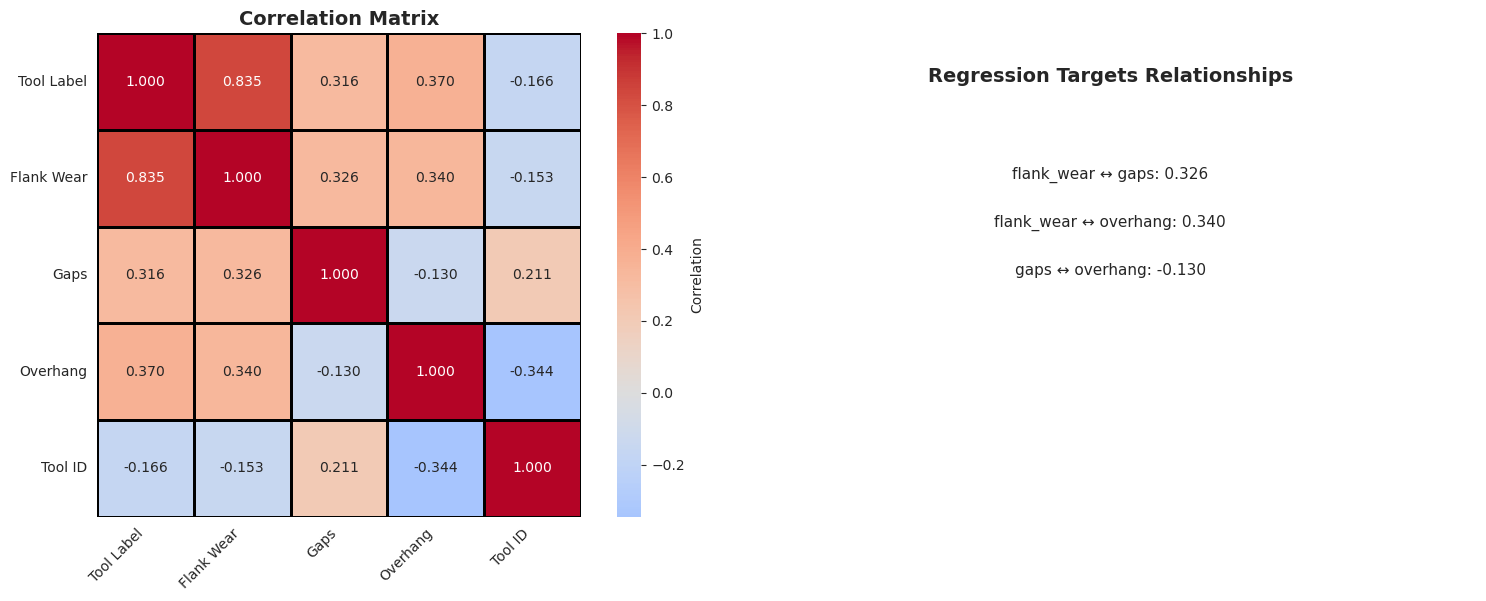

CORRELATION ANALYSIS

 Key Correlations:
   Tool Label ↔ Flank Wear: 0.835
   Tool Label ↔ Gaps:       0.316
   Tool Label ↔ Overhang:   0.370

   Flank Wear ↔ Gaps:      0.326
   Flank Wear ↔ Overhang:  0.340
   Gaps ↔ Overhang:        -0.130


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation matrix
corr_cols = ['tool_label', 'flank_wear', 'gaps', 'overhang', 'tool']
corr_matrix = full_df[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=axes[0], cbar_kws={'label': 'Correlation'},
            linewidths=1, linecolor='black')
axes[0].set_title('Correlation Matrix', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Tool Label', 'Flank Wear', 'Gaps', 'Overhang', 'Tool ID'], 
                        rotation=45, ha='right')
axes[0].set_yticklabels(['Tool Label', 'Flank Wear', 'Gaps', 'Overhang', 'Tool ID'], 
                        rotation=0)

# 2. Pairplot for regression targets
from pandas.plotting import scatter_matrix

scatter_cols = ['flank_wear', 'gaps', 'overhang']
scatter_df = full_df[scatter_cols]
axes[1].axis('off')
axes[1].text(0.5, 0.9, 'Regression Targets Relationships', 
             ha='center', fontsize=14, fontweight='bold', transform=axes[1].transAxes)

y_pos = 0.7
for i, target1 in enumerate(scatter_cols):
    for j, target2 in enumerate(scatter_cols):
        if i < j:
            corr = full_df[[target1, target2]].corr().iloc[0, 1]
            text = f"{target1} ↔ {target2}: {corr:.3f}"
            axes[1].text(0.5, y_pos, text, ha='center', fontsize=11, 
                        transform=axes[1].transAxes)
            y_pos -= 0.1

plt.tight_layout()
plt.show()

print("CORRELATION ANALYSIS")

print("\n Key Correlations:")
print(f"   Tool Label ↔ Flank Wear: {corr_matrix.loc['tool_label', 'flank_wear']:.3f}")
print(f"   Tool Label ↔ Gaps:       {corr_matrix.loc['tool_label', 'gaps']:.3f}")
print(f"   Tool Label ↔ Overhang:   {corr_matrix.loc['tool_label', 'overhang']:.3f}")
print(f"\n   Flank Wear ↔ Gaps:      {corr_matrix.loc['flank_wear', 'gaps']:.3f}")
print(f"   Flank Wear ↔ Overhang:  {corr_matrix.loc['flank_wear', 'overhang']:.3f}")
print(f"   Gaps ↔ Overhang:        {corr_matrix.loc['gaps', 'overhang']:.3f}")

In [7]:
import random

print("IMAGE MODALITY ANALYSIS")

modalities = ['chip', 'tool', 'work']
scal_spec = ['scal/x', 'scal/y', 'scal/z', 'spec/x', 'spec/y', 'spec/z']

sample_ids = full_df['id'].sample(min(10, len(full_df))).tolist()

image_stats = {mod: {'count': 0, 'sizes': []} for mod in modalities + scal_spec}

for sample_id in sample_ids:
    for mod in modalities + scal_spec:
        mod_path = os.path.join(data_dir, mod)
        for ext in ['.jpg', '.jpeg', '.png', '.JPG']:
            img_path = os.path.join(mod_path, f"{sample_id}{ext}")
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    image_stats[mod]['count'] += 1
                    image_stats[mod]['sizes'].append(img.size)
                    break
                except:
                    pass
for mod in modalities:
    if image_stats[mod]['count'] > 0:
        sizes = image_stats[mod]['sizes']
        unique_sizes = set(sizes)
        print(f"\n   {mod.upper()}:")
        print(f"      Sizes: {unique_sizes}")

print(f"\n   SCALOGRAMS & SPECTROGRAMS:")
for mod in scal_spec:
    if image_stats[mod]['count'] > 0:
        sizes = image_stats[mod]['sizes']
        print(f"      {mod}: {set(sizes)}")

IMAGE MODALITY ANALYSIS

   CHIP:
      Sizes: {(1024, 1024)}

   TOOL:
      Sizes: {(3100, 1000), (1550, 500)}

   WORK:
      Sizes: {(512, 512)}

   SCALOGRAMS & SPECTROGRAMS:
      scal/x: {(496, 369)}
      scal/y: {(496, 369)}
      scal/z: {(496, 369)}
      spec/x: {(495, 369)}
      spec/y: {(495, 369)}
      spec/z: {(495, 369)}


In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

sample_ids_per_class = []
actual_classes = []
for cls in [1, 2, 3]:
    sample = full_df[full_df['tool_label'] == cls].sample(1)
    sample_ids_per_class.append(sample['id'].values[0])
    actual_classes.append(sample['tool_label'].values[0])

modalities = ['chip', 'tool', 'work']
modality_names = ['Chip', 'Tool', 'Workpiece']
class_names = {1: 'Sharp (Class 1)', 2: 'Used (Class 2)', 3: 'Dulled (Class 3)'}

for row, (sample_id, cls) in enumerate(zip(sample_ids_per_class, actual_classes)):
    for col, (mod, mod_name) in enumerate(zip(modalities, modality_names)):
        mod_path = os.path.join(data_dir, mod)
        
        img = None
        for ext in ['.jpg', '.jpeg', '.png', '.JPG']:
            img_path = os.path.join(mod_path, f"{sample_id}{ext}")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                break
        
        if img is not None:
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            
            # Add class name on left
            if col == 0:
                axes[row, col].text(-0.1, 0.5, class_names[cls], 
                                   rotation=90, va='center', ha='right',
                                   fontsize=14, fontweight='bold',
                                   transform=axes[row, col].transAxes)
            
            # Add modality name on top
            if row == 0:
                axes[row, col].set_title(mod_name, fontsize=14, fontweight='bold', pad=10)
        else:
            axes[row, col].text(0.5, 0.5, 'Image Not Found', 
                               ha='center', va='center', fontsize=10)
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [28]:
class Config:
    nonastreda_dir = r"/scratch/tbalamur/final_project/Nonastreda_Multimodal"
    checkpoint_dir = "checkpoints_minape"
    results_dir = "results_minape"

    num_folds = 10  
    
    # Minape Architecture Parameters
    patch_size = 16  
    embedding_dim = 128
    num_heads = 8
    num_layers = 3  
    mlp_ratio = 4.0
    dropout = 0.1
    
    # Task heads
    num_classes = 3  # Sharp, Used, Dulled
    num_reg_targets = 3  # flank_wear, gaps, overhang
    
    # Training
    batch_size = 32
    epochs = 30
    learning_rate = 2e-4
    weight_decay = 1e-5
    patience = 10
    
    # Loss weights (multi-task)
    alpha_class = 1.0
    alpha_reg = 1.0

    use_reg_normalization = True
    reg_mean = None
    reg_std = None
    
    device = device

config = Config()
os.makedirs(config.checkpoint_dir, exist_ok=True)
os.makedirs(config.results_dir, exist_ok=True)

print(f"\n Configuration:")
print(f"   Dataset: {config.nonastreda_dir}")
print(f"   Folds: {config.num_folds}")
print(f"   Patch Size: {config.patch_size}")
print(f"   Embedding Dim: {config.embedding_dim}")
print(f"   Transformer Layers: {config.num_layers}")


 Configuration:
   Dataset: /scratch/tbalamur/final_project/Nonastreda_Multimodal
   Folds: 10
   Patch Size: 16
   Embedding Dim: 128
   Transformer Layers: 3


In [29]:

from cv_dataset_loader import NonastredaDatasetCV
import torch

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])
import pandas as pd

labels_reg_df = pd.read_csv("Nonastreda_Multimodal/labels_reg.csv")

print(f"Shape: {labels_reg_df.shape}")
print(f"\nFirst few rows:")
print(labels_reg_df.head())

print("REGRESSION TARGET STATISTICS")

for col in ['flank_wear', 'gaps', 'overhang']:
    if col in labels_reg_df.columns:
        print(f"\n{col}:")
        print(f"  Min:  {labels_reg_df[col].min():.2f}")
        print(f"  Max:  {labels_reg_df[col].max():.2f}")
        print(f"  Mean: {labels_reg_df[col].mean():.2f}")
        print(f"  Std:  {labels_reg_df[col].std():.2f}")
        print(f"  NaN:  {labels_reg_df[col].isnull().sum()}")

        if labels_reg_df[col].isnull().any():
            print(f"Contains NaN values!")

        extreme = labels_reg_df[col].abs() > 500
        if extreme.any():
            print(f"  {extreme.sum()} values have magnitude > 500")

original_getitem = NonastredaDatasetCV.__getitem__

def fixed_getitem(self, idx):
    chip, tool, work, scalos, specs, class_label, regression_targets = original_getitem(idx)

    class_label = class_label - 1
    regression_targets = torch.nan_to_num(regression_targets, nan=0.0, posinf=100.0, neginf=-100.0)
    regression_targets = torch.clamp(regression_targets, -100, 100)

    return chip, tool, work, scalos, specs, class_label, regression_targets

    NonastredaDatasetCV.__getitem__ = fixed_getitem

Shape: (512, 4)

First few rows:
       id  gaps  flank_wear  overhang
0  T1R2B1  7.67       34.89     48.61
1  T1R2B2  0.00       52.50     25.75
2  T1R2B3  7.07       52.76     21.56
3  T1R2B4  0.00       44.50      9.43
4  T1R3B1  9.44       39.90     17.89
REGRESSION TARGET STATISTICS

flank_wear:
  Min:  22.55
  Max:  346.66
  Mean: 87.86
  Std:  45.52
  NaN:  0

gaps:
  Min:  0.00
  Max:  154.56
  Mean: 8.20
  Std:  15.05
  NaN:  0

overhang:
  Min:  0.00
  Max:  76.75
  Mean: 20.95
  Std:  11.78
  NaN:  0


In [30]:
class PatchEmbedding(nn.Module):

    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2  # 16x16 = 256 patches
        
        # Projection: Conv2d acts as linear projection of flattened patches
        self.projection = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
        # Positional embedding (learnable)
        self.position_embedding = nn.Parameter(
            torch.randn(1, self.n_patches, embed_dim)
        )
        
    def forward(self, x):

        x = self.projection(x)  # (B, embed_dim, 16, 16)
        x = x.flatten(2)  # (B, embed_dim, 256)
        x = x.transpose(1, 2)  # (B, 256, embed_dim)

        x = x + self.position_embedding
        
        return x  # (B, n_patches, embed_dim)


In [31]:
class IsotropicBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(
            embed_dim, 
            num_heads, 
            dropout=dropout,
            batch_first=True
        )
        
        # MLP
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):

        x_norm = self.norm1(x)
        attn_out, attn_weights = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        
        return x, attn_weights


In [32]:
class TempMixer(nn.Module):
    def __init__(self, embed_dim=256, num_modalities=9):
        super().__init__()
        self.num_modalities = num_modalities
        
        # Cross-modal attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Modality-specific gating
        self.gate = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 4),
            nn.ReLU(),
            nn.Linear(embed_dim // 4, num_modalities),
            nn.Softmax(dim=-1)
        )
        
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, modality_tokens):
        # Stack modalities: (B, num_modalities*n_patches, embed_dim)
        stacked = torch.cat(modality_tokens, dim=1)
        
        # Cross-modal attention
        mixed, attn_weights = self.cross_attn(stacked, stacked, stacked)
        mixed = self.norm(mixed + stacked)
        
        # Global average pooling per modality
        B, total_patches, D = mixed.shape
        patches_per_mod = total_patches // self.num_modalities
        
        # Reshape and pool: (B, num_modalities, embed_dim)
        mixed_reshaped = mixed.view(B, self.num_modalities, patches_per_mod, D)
        pooled = mixed_reshaped.mean(dim=2)  # (B, num_modalities, embed_dim)
        
        # Compute modality importance gates
        gate_input = pooled.mean(dim=1)  # (B, embed_dim)
        gates = self.gate(gate_input)  # (B, num_modalities)
        
        # Weighted fusion
        gates = gates.unsqueeze(-1)  # (B, num_modalities, 1)
        fused = (pooled * gates).sum(dim=1)  # (B, embed_dim)
        
        return fused, gates, attn_weights


In [33]:
class MinapeNonastreda(nn.Module):

    def __init__(self, config):
        super().__init__()
        config.dropout = 0.5
        # Patch embeddings for each modality
        self.patch_embed_chip = PatchEmbedding(
            img_size=256, 
            patch_size=config.patch_size,
            in_channels=3, 
            embed_dim=config.embedding_dim
        )
        self.patch_embed_tool = PatchEmbedding(
            img_size=256, 
            patch_size=config.patch_size,
            in_channels=3, 
            embed_dim=config.embedding_dim
        )
        self.patch_embed_work = PatchEmbedding(
            img_size=256, 
            patch_size=config.patch_size,
            in_channels=3, 
            embed_dim=config.embedding_dim
        )
        self.patch_embed_scalo = PatchEmbedding(
            img_size=256, 
            patch_size=config.patch_size,
            in_channels=3,  # x, y, z axes stacked
            embed_dim=config.embedding_dim
        )
        self.patch_embed_spec = PatchEmbedding(
            img_size=256, 
            patch_size=config.patch_size,
            in_channels=3,  # x, y, z axes stacked
            embed_dim=config.embedding_dim
        )
        
        # Isotropic transformer layers (same for all modalities)
        self.transformer_layers = nn.ModuleList([
            IsotropicBlock(
                embed_dim=config.embedding_dim,
                num_heads=config.num_heads,
                mlp_ratio=config.mlp_ratio,
                dropout=config.dropout
            )
            for _ in range(config.num_layers)
        ])
        
        # TempMixer for cross-modal fusion
        self.temp_mixer = TempMixer(
            embed_dim=config.embedding_dim,
            num_modalities=5  # 5 modality groups
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.embedding_dim),
            nn.Dropout(0.5),
            nn.Linear(config.embedding_dim, config.embedding_dim // 2),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(config.embedding_dim // 2, config.num_classes)
        )
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.LayerNorm(config.embedding_dim),
            nn.Linear(config.embedding_dim, config.embedding_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.embedding_dim // 2, config.num_reg_targets)
        )
        
    def forward(self, chip, tool, work, scalos, specs):
        # Patch embedding for each modality
        chip_tokens = self.patch_embed_chip(chip)  # (B, 256, D)
        tool_tokens = self.patch_embed_tool(tool)  # (B, 256, D)
        work_tokens = self.patch_embed_work(work)  # (B, 256, D)
        scalo_tokens = self.patch_embed_scalo(scalos)  # (B, 256, D)
        spec_tokens = self.patch_embed_spec(specs)  # (B, 256, D)
        
        modality_processed = []
        attention_maps = []
        
        for tokens in [chip_tokens, tool_tokens, work_tokens, scalo_tokens, spec_tokens]:
            x = tokens
            for layer in self.transformer_layers:
                x, attn = layer(x)
            modality_processed.append(x)
            attention_maps.append(attn)
        
        # Fuse modalities with TempMixer
        fused, gates, cross_attn = self.temp_mixer(modality_processed)
        
        # Task heads
        class_logits = self.classifier(fused)
        regression = self.regressor(fused)
        
        return {
            'class_logits': class_logits,
            'regression': regression,
            'fused': fused,
            'gates': gates,  # Modality importance
            'attention': attention_maps[-1]  # Last layer attention
        }

print(f"   Architecture: Patch-based with {config.num_layers} isotropic layers")
print(f"   Modalities: 5 groups (chip, tool, work, scalograms, spectrograms)")

   Architecture: Patch-based with 3 isotropic layers
   Modalities: 5 groups (chip, tool, work, scalograms, spectrograms)


In [34]:
class MultiTaskLoss(nn.Module):
    def __init__(self, alpha_class=1.0, alpha_reg=1.0):
        super().__init__()
        self.alpha_class = alpha_class
        self.alpha_reg = alpha_reg

        self.classification_loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.regression_loss = nn.MSELoss()

    def forward(self, outputs, class_labels, regression_targets):
        # Clean regression targets to prevent numerical issues
        regression_targets = torch.nan_to_num(
            regression_targets,
            nan=0.0,
            posinf=100.0,
            neginf=-100.0
        )
        regression_targets = torch.clamp(regression_targets, -100, 100)

        # Compute losses
        loss_class = self.classification_loss(outputs['class_logits'], class_labels)
        loss_reg = self.regression_loss(outputs['regression'], regression_targets)

        total_loss = (
            self.alpha_class * loss_class +
            self.alpha_reg * loss_reg
        )

        return total_loss, {
            'classification': loss_class.item(),
            'regression': loss_reg.item()
        }


In [35]:
from cv_dataset_loader import NonastredaDatasetCV, create_cv_dataloaders

# Test with fold 1
import sys
import importlib

if 'cv_dataset_loader' in sys.modules:
    del sys.modules['cv_dataset_loader']

from cv_dataset_loader import NonastredaDatasetCV, create_cv_dataloaders

import inspect
source = inspect.getsource(NonastredaDatasetCV.__getitem__)
if "row['tool_label'] - 1" in source:
    print(" ")
else:
    
    original_getitem = NonastredaDatasetCV.__getitem__

    def fixed_getitem(self, idx):
        chip, tool, work, scalos, specs, class_label, regression_targets = original_getitem(self, idx)

        class_label = class_label - 1

        import torch
        regression_targets = torch.nan_to_num(regression_targets, nan=0.0, posinf=100.0, neginf=-100.0)
        regression_targets = torch.clamp(regression_targets, -100, 100)

        return chip, tool, work, scalos, specs, class_label, regression_targets

    NonastredaDatasetCV.__getitem__ = fixed_getitem
    
test_tool = 1
train_loader, test_loader = create_cv_dataloaders(
    config.nonastreda_dir,
    test_tool=test_tool,
    batch_size=config.batch_size,
    train_transform=train_transform,
    val_transform=val_transform
)

print(f"\n Data loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

for chip, tool, work, scalos, specs, class_labels, reg_targets in train_loader:
    print(f"\nBatch shapes:")
    print(f"   Chip: {chip.shape}")
    print(f"   Tool: {tool.shape}")
    print(f"   Work: {work.shape}")
    print(f"   Scalograms: {scalos.shape}")
    print(f"   Spectrograms: {specs.shape}")
    print(f"   Class labels: {class_labels.shape}")
    print(f"   Regression targets: {reg_targets.shape}")
    break
for chip, tool, work, scalos, specs, class_labels, reg_targets in train_loader:
    print(f"   Class labels range: [{class_labels.min()}, {class_labels.max()}]")
    print(f"   Unique labels: {sorted(class_labels.unique().tolist())}")

    if class_labels.min() < 0 or class_labels.max() > 2:
        raise ValueError("Dataset fix not loaded!")
    else:
        print(f"    Labels are CORRECT [0,1,2]")
    break

 
Loaded 472 samples
   Mode: train | Using tools: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] | Excluded: T1
Loaded 40 samples
   Mode: test | Testing on tool: T1

 Data loaders created
   Train batches: 15
   Test batches: 2

Batch shapes:
   Chip: torch.Size([32, 3, 256, 256])
   Tool: torch.Size([32, 3, 256, 256])
   Work: torch.Size([32, 3, 256, 256])
   Scalograms: torch.Size([32, 3, 256, 256])
   Spectrograms: torch.Size([32, 3, 256, 256])
   Class labels: torch.Size([32])
   Regression targets: torch.Size([32, 3])
   Class labels range: [0, 2]
   Unique labels: [0, 1, 2]
    Labels are CORRECT [0,1,2]


In [36]:
def compute_reg_stats(dataloader):
    all_targets = []
    for _, _, _, _, _, _, reg_targets in dataloader:
        all_targets.append(reg_targets)
    all_targets = torch.cat(all_targets, dim=0)
    mean = all_targets.mean(dim=0)
    std = all_targets.std(dim=0) + 1e-6
    return mean, std

reg_mean, reg_std = compute_reg_stats(train_loader)
print(f"\n Regression Normalization Stats:")
print(f"   Mean: {reg_mean.numpy()}")
print(f"   Std:  {reg_std.numpy()}")

config.reg_mean = reg_mean.to(config.device)
config.reg_std = reg_std.to(config.device)
config.use_reg_normalization = True

print(f"\n Normalization enabled and stats stored in config")


 Regression Normalization Stats:
   Mean: [88.02879   8.245678 20.710869]
   Std:  [46.60716  15.549901 11.881917]

 Normalization enabled and stats stored in config


In [37]:
def train_epoch(model, dataloader, optimizer, criterion, device, epoch):
   model.train()
   total_loss = 0
   loss_dict_sum = {'classification': 0, 'regression': 0}


   pbar = tqdm(dataloader, desc=f"Epoch {epoch} - Training")


   for batch_idx, (chip, tool, work, scalos, specs, class_labels, reg_targets) in enumerate(pbar):
       try:
           chip = chip.to(device)
           tool = tool.to(device)
           work = work.to(device)
           scalos = scalos.to(device).float()
           specs = specs.to(device).float()
           class_labels = class_labels.to(device)
           reg_targets = reg_targets.to(device).float()

           reg_targets = torch.nan_to_num(reg_targets, nan=0.0, posinf=100.0, neginf=-100.0)
           reg_targets = torch.clamp(reg_targets, -100, 100)
           if hasattr(config, 'use_reg_normalization') and config.use_reg_normalization:
                if config.reg_mean is not None and config.reg_std is not None:
                    reg_targets = (reg_targets - config.reg_mean) / config.reg_std
                    if batch_idx == 0 and epoch == 1:
                        print(f"\nRegression normalized: range=[{reg_targets.min():.2f}, {reg_targets.max():.2f}]")
                else:
                    print("Warning: Normalization enabled but stats not computed. Skipping normalization.")

           outputs = model(chip, tool, work, scalos, specs)


           loss, loss_dict = criterion(outputs, class_labels, reg_targets)

           if torch.isnan(loss) or torch.isinf(loss):
               print(f"\n  Skipping batch {batch_idx} - invalid loss")
               continue

           optimizer.zero_grad()
           loss.backward()
           torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
           optimizer.step()

           total_loss += loss.item()
           loss_dict_sum['classification'] += loss_dict['classification']
           loss_dict_sum['regression'] += loss_dict['regression']

           pbar.set_postfix({
            'loss': loss.item(),
            'cls': loss_dict['classification'],
            'reg': loss_dict['regression']
        })


       except RuntimeError as e:
           print(f"\n Error at batch {batch_idx}: {e}")
           if torch.cuda.is_available():
               torch.cuda.empty_cache()
           continue


   avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
   avg_cls_loss = loss_dict_sum['classification'] / len(dataloader) if len(dataloader) > 0 else 0
   avg_reg_loss = loss_dict_sum['regression'] / len(dataloader) if len(dataloader) > 0 else 0


   return avg_loss, {'classification': avg_cls_loss, 'regression': avg_reg_loss}

In [38]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    all_class_preds = []
    all_class_labels = []
    all_reg_preds = []
    all_reg_targets = []
    all_gates = []

    with torch.no_grad():
        for chip, tool, work, scalos, specs, class_labels, reg_targets in tqdm(dataloader, desc="Evaluating"):
            chip = chip.to(device)
            tool = tool.to(device)
            work = work.to(device)
            scalos = scalos.to(device).float()
            specs = specs.to(device).float()
            class_labels = class_labels.to(device)
            reg_targets = reg_targets.to(device).float()

            reg_targets = torch.nan_to_num(reg_targets, nan=0.0, posinf=100.0, neginf=-100.0)
            reg_targets = torch.clamp(reg_targets, -100, 100)
            if hasattr(config, 'use_reg_normalization') and config.use_reg_normalization:
                if config.reg_mean is not None and config.reg_std is not None:
                    reg_targets = (reg_targets - config.reg_mean) / config.reg_std

            outputs = model(chip, tool, work, scalos, specs)

            # Compute loss
            loss, _ = criterion(outputs, class_labels, reg_targets)
            total_loss += loss.item()

            # Collect predictions
            class_preds = torch.argmax(outputs['class_logits'], dim=1)
            all_class_preds.extend(class_preds.cpu().numpy())
            all_class_labels.extend(class_labels.cpu().numpy())
            all_reg_preds.extend(outputs['regression'].cpu().numpy())
            all_reg_targets.extend(reg_targets.cpu().numpy())
            all_gates.append(outputs['gates'].cpu().numpy())

    # Convert to numpy
    all_class_preds = np.array(all_class_preds)
    all_class_labels = np.array(all_class_labels)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_targets = np.array(all_reg_targets)
    all_gates = np.concatenate(all_gates, axis=0)

    # Classification metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    accuracy = accuracy_score(all_class_labels, all_class_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_class_labels, all_class_preds, average='macro', zero_division=0
    )

    # Regression metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(all_reg_targets, all_reg_preds)
    rmse = np.sqrt(mean_squared_error(all_reg_targets, all_reg_preds))

    # Per-target MAE
    mae_per_target = np.mean(np.abs(all_reg_targets - all_reg_preds), axis=0)

    return {
        'loss': total_loss / len(dataloader),
        'classification': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_class_preds,
            'labels': all_class_labels
        },
        'regression': {
            'mae': mae,
            'rmse': rmse,
            'mae_flank_wear': mae_per_target[0],
            'mae_gaps': mae_per_target[1],
            'mae_overhang': mae_per_target[2],
            'predictions': all_reg_preds,
            'targets': all_reg_targets
        },
        'gates': all_gates
    }

In [20]:
print("DATA DIAGNOSTICS")

# Check class distribution
all_labels = []
all_reg_targets = []

for _, _, _, _, _, class_labels, reg_targets in train_loader:
    all_labels.extend(class_labels.numpy())
    all_reg_targets.append(reg_targets.numpy())

all_reg_targets = np.concatenate(all_reg_targets, axis=0)

# Class distribution
import collections
label_counts = collections.Counter(all_labels)
print(f"\nClass Distribution in Training Set:")
for label, count in sorted(label_counts.items()):
    print(f"  Class {label}: {count} samples ({count/len(all_labels)*100:.1f}%)")

# Regression statistics
print(f"\nRegression Target Statistics:")
print(f"  Flank Wear: mean={all_reg_targets[:, 0].mean():.2f}, std={all_reg_targets[:, 0].std():.2f}")
print(f"  Gaps:       mean={all_reg_targets[:, 1].mean():.2f}, std={all_reg_targets[:, 1].std():.2f}")
print(f"  Overhang:   mean={all_reg_targets[:, 2].mean():.2f}, std={all_reg_targets[:, 2].std():.2f}")
print(f"  Overall:    mean={all_reg_targets.mean():.2f}, std={all_reg_targets.std():.2f}")


DATA DIAGNOSTICS

Class Distribution in Training Set:
  Class 0: 180 samples (38.1%)
  Class 1: 152 samples (32.2%)
  Class 2: 140 samples (29.7%)

Regression Target Statistics:
  Flank Wear: mean=88.03, std=46.56
  Gaps:       mean=8.25, std=15.53
  Overhang:   mean=20.71, std=11.87
  Overall:    mean=39.00, std=45.58


In [23]:

model = MinapeNonastreda(config).to(config.device)

def clean_regression_targets(reg_targets):
      reg_targets = torch.nan_to_num(
        reg_targets,
        nan=0.0,
        posinf=1000.0,
        neginf=-1000.0
      )
      return torch.clamp(reg_targets, -1000, 1000)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
reg_targets = clean_regression_targets(reg_targets)
all_labels = []
for _, _, _, _, _, class_labels, _ in train_loader:

  all_labels.extend(class_labels.numpy())

import collections  
label_counts = collections.Counter(all_labels)
print(f"\nClass distribution:")
for label, count in sorted(label_counts.items()):
  print(f"  Class {label}: {count} samples ({count/len(all_labels)*100:.1f}%)")

print(f"\nModel initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Test forward pass
model.eval()
with torch.no_grad():
    outputs = model(
        chip.to(config.device), 
        tool.to(config.device), 
        work.to(config.device), 
        scalos.to(config.device).float(), 
        specs.to(config.device).float()
    )
    print(f"\n Output shapes:")
    print(f"   Class logits: {outputs['class_logits'].shape}")
    print(f"   Regression: {outputs['regression'].shape}")
    print(f"   Fused features: {outputs['fused'].shape}")
    print(f"   Modality gates: {outputs['gates'].shape}")
    print(f"\n Modality importance (sample):")
    print(f"   {outputs['gates'][0].cpu().numpy()}")
    print(f"   Order: [chip, tool, work, scalogram, spectrogram]")


Class distribution:
  Class 0: 180 samples (38.1%)
  Class 1: 152 samples (32.2%)
  Class 2: 140 samples (29.7%)

Model initialized
   Total parameters: 1,338,827
   Trainable parameters: 1,338,827
   Model size: ~5.11 MB

 Output shapes:
   Class logits: torch.Size([32, 3])
   Regression: torch.Size([32, 3])
   Fused features: torch.Size([32, 128])
   Modality gates: torch.Size([32, 5, 1])

 Modality importance (sample):
   [[0.21340711]
 [0.16598696]
 [0.2131208 ]
 [0.17919225]
 [0.22829285]]
   Order: [chip, tool, work, scalogram, spectrogram]


In [ ]:
import time

print(f"  {config.num_folds}-FOLD CROSS-VALIDATION")
print(f"   Each fold: train on 9 tools, test on 1 tool")

start_time = time.time()
results_per_fold = []

for fold in range(1, config.num_folds + 1):
    print(f"\n{'='*70}")
    print(f"  FOLD {fold}/{config.num_folds} - Testing on Tool T{fold}")
    print(f"{'='*70}")
    
    # Create dataloaders
    train_loader, test_loader = create_cv_dataloaders(
        config.nonastreda_dir,
        test_tool=fold,
        batch_size=config.batch_size,
        train_transform=train_transform,
        val_transform=val_transform
    )
    
    # Create fresh model
    model = MinapeNonastreda(config).to(config.device)
    
    # Setup training
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate, 
        weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config.epochs
    )
    criterion = MultiTaskLoss(
        alpha_class=10.0,
        alpha_reg=0.01
    )
    
    # Training loop
    best_accuracy = 0
    best_f1 = 0
    patience_counter = 0
    
    for epoch in range(1, config.epochs + 1):
        # Train
        train_loss, train_loss_dict = train_epoch(
            model, train_loader, optimizer, criterion, config.device, epoch
        )
        
        # Evaluate
        test_results = evaluate(model, test_loader, criterion, config.device)
        
        # Print progress
        if epoch % 5 == 0 or epoch == 1:
            print(f"\n   Epoch {epoch:2d}/{config.epochs}:")
            print(f"      Train Loss: {train_loss:.4f}")
            print(f"      Test Acc: {test_results['classification']['accuracy']:.4f}")
            print(f"      Test F1: {test_results['classification']['f1']:.4f}")
            print(f"      Test MAE: {test_results['regression']['mae']:.2f} µm")
        
        # Save best model
        if test_results['classification']['accuracy'] > best_accuracy:
            best_accuracy = test_results['classification']['accuracy']
            best_f1 = test_results['classification']['f1']
            best_results = test_results
            patience_counter = 0
            
            torch.save({
                'fold': fold,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': test_results,
                'config': config
            }, f'{config.checkpoint_dir}/fold_{fold}_best.pth')
        else:
            patience_counter += 1
        
        scheduler.step()
        
        # Early stopping
        if patience_counter >= config.patience:
            print(f"\n   Early stopping at epoch {epoch}")
            break
    
    # Store results
    results_per_fold.append({
        'fold': fold,
        'test_tool': fold,
        'accuracy': best_results['classification']['accuracy'],
        'f1': best_results['classification']['f1'],
        'mae': best_results['regression']['mae'],
        'rmse': best_results['regression']['rmse'],
        'mae_flank_wear': best_results['regression']['mae_flank_wear'],
        'mae_gaps': best_results['regression']['mae_gaps'],
        'mae_overhang': best_results['regression']['mae_overhang'],
        'modality_gates': best_results['gates'].mean(axis=0)  # Average importance
    })
    
    print(f"\n   Fold {fold} Complete:")
    print(f"      Best Accuracy: {best_accuracy:.4f}")
    print(f"      Best F1: {best_f1:.4f}")
    print(f"      MAE: {best_results['regression']['mae']:.2f} µm")
    print(f"      Average Modality Importance:")
    modality_names = ['Chip', 'Tool', 'Work', 'Scalogram', 'Spectrogram']
    gates_mean = best_results['gates'].mean(axis=0).flatten()  # Flatten to 1D
    for name, importance in zip(modality_names, gates_mean):
        importance_val = float(importance)  # Convert to Python float
        print(f"         {name}: {importance_val:.3f}")
    
    # Clean up
    del model, optimizer, scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

elapsed = time.time() - start_time
print(f"{config.num_folds}-FOLD CV COMPLETE!")

  10-FOLD CROSS-VALIDATION
   Each fold: train on 9 tools, test on 1 tool

  FOLD 1/10 - Testing on Tool T1
Loaded 472 samples
   Mode: train | Using tools: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] | Excluded: T1
Loaded 40 samples
   Mode: test | Testing on tool: T1


Epoch 1 - Training:   7%| | 1/15 [00:03<00:48,  3.46s/it, loss=10.3, cls=1.03, r


Regression normalized: range=[-1.39, 2.34]


Epoch 1 - Training: 100%|█| 15/15 [00:54<00:00,  3.61s/it, loss=8.63, cls=0.862,
Evaluating: 100%|█████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]



   Epoch  1/30:
      Train Loss: 9.8689
      Test Acc: 0.7000
      Test F1: 0.5758
      Test MAE: 0.45 µm


Epoch 2 - Training:   0%|                                | 0/15 [00:00<?, ?it/s]


In [ ]:
print("  AGGREGATED RESULTS ACROSS ALL FOLDS")

# Convert to DataFrame
results_df = pd.DataFrame(results_per_fold)

# Save to CSV
results_df.to_csv(f'{config.results_dir}/cv_results.csv', index=False)

# Classification metrics
print(f"\n Classification Performance:")
print(f"   Accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"   F1 Score: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")
print(f"   Best Fold: T{results_df.loc[results_df['accuracy'].idxmax(), 'test_tool']:.0f} ({results_df['accuracy'].max():.4f})")
print(f"   Worst Fold: T{results_df.loc[results_df['accuracy'].idxmin(), 'test_tool']:.0f} ({results_df['accuracy'].min():.4f})")

# Regression metrics
print(f"\n Regression Performance:")
print(f"   Overall MAE: {results_df['mae'].mean():.2f} ± {results_df['mae'].std():.2f} µm")
print(f"   Overall RMSE: {results_df['rmse'].mean():.2f} ± {results_df['rmse'].std():.2f} µm")
print(f"\n   Per-target MAE:")
print(f"      Flank Wear: {results_df['mae_flank_wear'].mean():.2f} ± {results_df['mae_flank_wear'].std():.2f} µm")
print(f"      Gaps: {results_df['mae_gaps'].mean():.2f} ± {results_df['mae_gaps'].std():.2f} µm")
print(f"      Overhang: {results_df['mae_overhang'].mean():.2f} ± {results_df['mae_overhang'].std():.2f} µm")

# Modality importance
print(f"\n Average Modality Importance:")
avg_gates = np.array([r['modality_gates'] for r in results_per_fold]).mean(axis=0)
modality_names = ['Chip', 'Tool', 'Work', 'Scalogram', 'Spectrogram']
gates_mean = best_results['gates'].mean(axis=0).flatten()  # Flatten to 1D
for name, importance in zip(modality_names, gates_mean):
    importance_val = float(importance)  # Convert to Python float
    print(f"         {name}: {importance_val:.3f}")



In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy per fold
axes[0, 0].bar(results_df['fold'], results_df['accuracy'], color='steelblue', alpha=0.8)
axes[0, 0].axhline(results_df['accuracy'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].set_xlabel('Fold (Test Tool)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Classification Accuracy per Fold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score per fold
axes[0, 1].bar(results_df['fold'], results_df['f1'], color='forestgreen', alpha=0.8)
axes[0, 1].axhline(results_df['f1'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].set_xlabel('Fold (Test Tool)')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('F1 Score per Fold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# MAE per fold
axes[1, 0].bar(results_df['fold'], results_df['mae'], color='coral', alpha=0.8)
axes[1, 0].axhline(results_df['mae'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].set_xlabel('Fold (Test Tool)')
axes[1, 0].set_ylabel('MAE (µm)')
axes[1, 0].set_title('Regression MAE per Fold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Modality importance
modality_names = ['Chip', 'Tool', 'Work', 'Scalogram', 'Spectrogram']
avg_gates_values = [float(g) for g in avg_gates.flatten()[:5]]  # Get first 5 values as floats

axes[1, 1].bar(modality_names, avg_gates_values, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Modality')
axes[1, 1].set_ylabel('Average Importance')
axes[1, 1].set_title('Learned Modality Importance (TempMixer Gates)')
axes[1, 1].tick_params(axis='x', rotation=45)

axes[1, 1].grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{config.results_dir}/cv_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Load best fold results
best_fold = results_df.loc[results_df['accuracy'].idxmax(), 'fold']
best_checkpoint = torch.load(
      f'{config.checkpoint_dir}/fold_{int(best_fold)}_best.pth',
      map_location=config.device,
      weights_only=False
  )
best_test_results = best_checkpoint['results']

# Confusion matrix
cm = confusion_matrix(
    best_test_results['classification']['labels'],
    best_test_results['classification']['predictions']
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sharp', 'Used', 'Dulled'],
            yticklabels=['Sharp', 'Used', 'Dulled'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Best Fold (T{int(best_fold)})\nAccuracy: {results_df.loc[results_df["fold"]==best_fold, "accuracy"].values[0]:.4f}')
plt.tight_layout()
plt.savefig(f'{config.results_dir}/confusion_matrix_best.png', dpi=300, bbox_inches='tight')
print(f" Saved confusion matrix to {config.results_dir}/confusion_matrix_best.png")
plt.show()

# Classification report
print("\n Classification Report (Best Fold):")
print(classification_report(
    best_test_results['classification']['labels'],
    best_test_results['classification']['predictions'],
    target_names=['Sharp', 'Used', 'Dulled'],
    digits=4
))

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import time

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset (no tool-based splitting)
from cv_dataset_loader import NonastredaDatasetCV

# Use test_tool=None and mode="train" to load ALL samples
full_dataset = NonastredaDatasetCV(
    root_dir="/scratch/tbalamur/final_project/Nonastreda_Multimodal",
    transform=val_transform,
    test_tool=None,  # No tool exclusion
    mode="train"     # Doesn't matter since test_tool=None
)

print(f"\nTotal samples: {len(full_dataset)}")

# Random 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_indices, test_indices = torch.utils.data.random_split(
    range(len(full_dataset)), 
    [train_size, test_size],
    generator=generator
)

print(f"Train samples: {len(train_indices)} (80%)")
print(f"Test samples: {len(test_indices)} (20%)")

# Create subset datasets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices.indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices.indices)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("="*70)

In [ ]:
import torch
import numpy as np

# Calculate regression statistics from training data
print("Calculating regression normalization statistics...")

all_reg_targets = []
for batch in train_loader:
    _, _, _, _, _, _, reg_targets = batch
    all_reg_targets.append(reg_targets.numpy())

all_reg_targets = np.concatenate(all_reg_targets, axis=0)

# Calculate mean and std for each regression target
reg_mean = torch.tensor(all_reg_targets.mean(axis=0), dtype=torch.float32).to(device)
reg_std = torch.tensor(all_reg_targets.std(axis=0), dtype=torch.float32).to(device)

print(f"\nRegression Target Statistics:")
print(f"   Flank Wear: mean={reg_mean[0]:.2f}, std={reg_std[0]:.2f}")
print(f"   Gaps:       mean={reg_mean[1]:.2f}, std={reg_std[1]:.2f}")
print(f"   Overhang:   mean={reg_mean[2]:.2f}, std={reg_std[2]:.2f}")

# Add normalization to dataset
class NormalizedDataLoader:
    def __init__(self, dataloader, reg_mean, reg_std):
        self.dataloader = dataloader
        self.reg_mean = reg_mean.cpu()
        self.reg_std = reg_std.cpu()
    
    def __iter__(self):
        for batch in self.dataloader:
            chip, tool, work, scalos, specs, class_labels, reg_targets = batch
            # Normalize regression targets
            reg_targets = (reg_targets - self.reg_mean) / (self.reg_std + 1e-8)
            yield chip, tool, work, scalos, specs, class_labels, reg_targets
    
    def __len__(self):
        return len(self.dataloader)

# Wrap dataloaders with normalization
train_loader_norm = NormalizedDataLoader(train_loader, reg_mean, reg_std)
test_loader_norm = NormalizedDataLoader(test_loader, reg_mean, reg_std)

print("\n✅ Regression normalization applied")
print(f"   Normalized range: approximately [-3, +3] standard deviations")

In [ ]:
from complete_multitask_standalone import (
    MultiTaskMultimodalModel,
    MultiTaskLoss,
    train_epoch_multitask,
    evaluate_multitask
)
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nInitializing model...")
model = MultiTaskMultimodalModel(
    embedding_dim=128,
    fusion_type='attention',
    num_classes=3,
    num_regression_targets=3
).to(device)

print(f"✅ Model initialized on {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
criterion = MultiTaskLoss(alpha_class=1.0, alpha_reg=1.0, alpha_recon=0.0)

# Training loop
best_accuracy = 0
best_f1 = 0
patience_counter = 0
patience = 7

print("\n" + "="*70)
print("TRAINING START (with normalized regression)")
print("="*70)

start_time = time.time()

for epoch in range(1, 31):
    # Train with normalized data
    train_loss, loss_dict = train_epoch_multitask(
        model, train_loader_norm, optimizer, criterion, device
    )
    
    # Evaluate with normalized data
    test_results = evaluate_multitask(
        model, test_loader_norm, criterion, device
    )
    
    test_results['regression']['mae_denorm'] = test_results['regression']['mae'] * reg_std.mean().item()
    test_results['regression']['rmse_denorm'] = test_results['regression']['rmse'] * reg_std.mean().item()
    
    scheduler.step()
    
    # Print every 5 epochs or first
    if epoch % 5 == 0 or epoch == 1:
        print(f"\n Epoch {epoch}/30:")
        print(f"    Train Loss: {train_loss:.4f}")
        print(f"      - Class Loss: {loss_dict['classification']:.4f}")
        print(f"      - Reg Loss:   {loss_dict['regression']:.4f}")
        print(f"    Test Acc:   {test_results['classification']['accuracy']:.4f}")
        print(f"    Test F1:    {test_results['classification']['f1']:.4f}")
        print(f"    Test MAE:   {test_results['regression']['mae']:.2f} µm ")
    
    # Save best model
    if test_results['classification']['accuracy'] > best_accuracy:
        best_accuracy = test_results['classification']['accuracy']
        best_f1 = test_results['classification']['f1']
        best_results = test_results.copy()
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results': test_results,
            'accuracy': best_accuracy,
            'reg_mean': reg_mean.cpu(),
            'reg_std': reg_std.cpu()
        }, 'best_model_random.pth')
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"    New best accuracy: {best_accuracy:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n    Early stopping at epoch {epoch}")
        break

elapsed = time.time() - start_time

print("RANDOM SPLIT TRAINING COMPLETE")
print(f"Best Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Best Test F1:       {best_f1:.4f}")
print(f"Best Test MAE:      {best_results['regression']['mae_denorm']:.2f} µm")
print(f"Best Test RMSE:     {best_results['regression']['rmse_denorm']:.2f} µm")
print(f"\nTraining time: {int(elapsed//60)}m {int(elapsed%60)}s")

# Average modality importance
if 'gates' in best_results:
    mean_gates = best_results['gates'].mean(axis=0)
    print(f"\nAverage Modality Importance:")
    print(f"   Chip:        {mean_gates[0]:.3f} ({mean_gates[0]*100:.1f}%)")
    print(f"   Tool:        {mean_gates[1]:.3f} ({mean_gates[1]*100:.1f}%)")
    print(f"   Work:        {mean_gates[2]:.3f} ({mean_gates[2]*100:.1f}%)")
    print(f"   Scalogram:   {mean_gates[3]:.3f} ({mean_gates[3]*100:.1f}%)")
    print(f"   Spectrogram: {mean_gates[4]:.3f} ({mean_gates[4]*100:.1f}%)")

print("="*70)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("COMPARISON: RANDOM SPLIT vs TOOL-BASED CV")

cv_results = {
    'folds': list(range(1, 11)),
    'accuracies': results_df['accuracy'],
    'f1_scores': results_df['f1'],
    'maes': results_df['mae']
}

cv_results['mean_acc'] = np.mean(cv_results['accuracies'])
cv_results['std_acc'] = np.std(cv_results['accuracies'])
cv_results['median_acc'] = np.median(cv_results['accuracies'])
cv_results['mean_f1'] = np.mean(cv_results['f1_scores'])
cv_results['mean_mae'] = np.mean(cv_results['maes'])

# Random split result
random_result = {
    'accuracy': best_accuracy,
    'f1': best_f1,
    'mae': best_results['regression']['mae']
}


print("\n1. RANDOM SPLIT (80/20 - Same Domain)")
print(f"   Accuracy: {random_result['accuracy']:.4f} ({random_result['accuracy']*100:.2f}%)")
print(f"   F1 Score: {random_result['f1']:.4f}")
print(f"   MAE:      {random_result['mae']:.2f} µm")

print("\n2. TOOL-BASED CV (10-Fold - Cross-Domain)")
print(f"   Mean Accuracy:   {cv_results['mean_acc']:.4f} ± {cv_results['std_acc']:.4f}")
print(f"   Median Accuracy: {cv_results['median_acc']:.4f}")
print(f"   Range:           [{min(cv_results['accuracies']):.3f}, {max(cv_results['accuracies']):.3f}]")
print(f"   Mean F1:         {cv_results['mean_f1']:.4f}")
print(f"   Mean MAE:        {cv_results['mean_mae']:.2f} µm")
gap = random_result['accuracy'] - cv_results['mean_acc']
gap_pct = (gap / cv_results['mean_acc']) * 100

print(f"   Accuracy Gap:     {gap:+.4f} ({gap*100:+.2f}%)")
print(f"   Relative Benefit: {gap_pct:+.1f}%")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Per-fold accuracies with random split line
axes[0].bar(cv_results['folds'], cv_results['accuracies'], 
            color='steelblue', alpha=0.7, edgecolor='black', label='Tool-based CV')
axes[0].axhline(cv_results['mean_acc'], color='red', linestyle='--', 
                linewidth=2.5, label=f'CV Mean: {cv_results["mean_acc"]:.3f}')
axes[0].axhline(random_result['accuracy'], color='green', linestyle='--', 
                linewidth=2.5, label=f'Random Split: {random_result["accuracy"]:.3f}')
axes[0].fill_between(cv_results['folds'], 
                      cv_results['mean_acc'] - cv_results['std_acc'],
                      cv_results['mean_acc'] + cv_results['std_acc'],
                      color='red', alpha=0.2, label='±1 Std Dev')
axes[0].set_xlabel('Fold (Test Tool)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Tool-Based CV: Per-Fold Performance', fontsize=15, fontweight='bold')
axes[0].set_ylim([0, 1.05])
axes[0].set_xticks(cv_results['folds'])
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Box plot comparison
data_to_plot = [cv_results['accuracies'], [random_result['accuracy']]]
bp = axes[1].boxplot(data_to_plot, 
                     labels=['Tool-Based CV\n(Cross-Domain)', 'Random Split\n(Same-Domain)'],
                     patch_artist=True, widths=0.5, showmeans=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('lightgreen')
bp['boxes'][1].set_alpha(0.7)

axes[1].scatter([1]*len(cv_results['accuracies']), cv_results['accuracies'], 
               color='darkblue', alpha=0.6, s=70, zorder=3, label='Individual folds')
axes[1].scatter([2], [random_result['accuracy']], 
               color='darkgreen', alpha=0.9, s=150, marker='D', 
               edgecolor='black', linewidth=2, zorder=3, label='Random split')

axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[1].set_title('Evaluation Strategy Comparison', fontsize=15, fontweight='bold')
axes[1].set_ylim([0, 1.05])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=10)

# Plot 3: Metrics comparison
metrics = ['Accuracy', 'F1 Score', 'MAE (µm)']
cv_values = [cv_results['mean_acc'], cv_results['mean_f1'], cv_results['mean_mae']]
random_values = [random_result['accuracy'], random_result['f1'], random_result['mae']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[2].bar(x - width/2, cv_values, width, label='Tool-Based CV', 
                    color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = axes[2].bar(x + width/2, random_values, width, label='Random Split', 
                    color='lightgreen', alpha=0.7, edgecolor='black', linewidth=1.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[2].set_ylabel('Value', fontsize=13, fontweight='bold')
axes[2].set_title('All Metrics Comparison', fontsize=15, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics, fontsize=12)
axes[2].legend(fontsize=11, loc='upper right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()